Demonstrates extraction of relevant flow data into hdf5 using `libtrace` and `pandas`

##### Getting trace for testing
1. Download a trace from [MAWI Traffic Archive](http://mawi.wide.ad.jp/mawi/) 
2. Trucate to a workable time duration (e.g. 1 minute) with [tracesplit](https://github.com/LibtraceTeam/libtrace/wiki/tracesplit): `tracesplit -i 60 -m 1 inputuri outputuri`

In [24]:
TRACE_PATH = '/tmp/anon-v4.pcap'
STORE_PATH = '/tmp/anon-v4.hdf5'

In [25]:
import os
import sys

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import plt as libtrace

from typing import Tuple

from utils.managed_trace import managed_trace
from utils.tcp_packet import read_tcp_packet, TCPPacket

We read from the trace, filtering TCP packets, and store the relevant fields of the packets in a list of namedtuples.

In [26]:
filter_ = libtrace.filter('tcp')
with managed_trace(TRACE_PATH) as trace:
    trace.conf_filter(filter_)
    tcp_packets = [read_tcp_packet(packet) for packet in trace]
tcp_df = pd.DataFrame.from_records(tcp_packets, columns=TCPPacket._fields)

Now we have a `dataframe` with the following columns:

In [27]:
list(tcp_df)

['timestamp',
 'flow_hash',
 'src_ip',
 'dst_ip',
 'src_port',
 'dst_port',
 'seq_nr',
 'ack_nr',
 'flags',
 'ts_val',
 'ts_ecr',
 'payload_length']

We store the `src_ip:src_port`, `dst_ip:dst_port` in a separate map

    flow_hash -> ((ip_a, src_a), (ip_b, src_b))
    
such that `ip_a < ip_b`. 

In [28]:
def sorted_tcp_tuple(packet) -> Tuple[Tuple[str, int], Tuple[str, int]]:
    src, dst = (str(packet.src_ip), packet.src_port), (str(packet.dst_ip), packet.dst_port)
    return (src, dst) if packet.src_ip < packet.dst_ip else (dst, src)

flow_to_tcp_tuple = {p.flow_hash: sorted_tcp_tuple(p) for p in tcp_df.itertuples()}

We remove these cols from the dataframe and store the direction of the packets as a boolean `src_ip < dst_ip` instead.

In [29]:
tcp_df['ip_direction_asc'] = (tcp_df.src_ip < tcp_df.dst_ip).astype(bool)
del tcp_df['src_ip']
del tcp_df['src_port']
del tcp_df['dst_ip']
del tcp_df['dst_port']

In [30]:
with pd.HDFStore(STORE_PATH) as store:
    store['tcp_df'] = tcp_df
    store.get_storer('tcp_df').attrs.flow_to_tcp_tuple = flow_to_tcp_tuple

## Stats

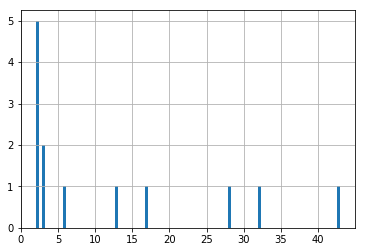

In [31]:
# Number of packets sent per flow
packet_counts = tcp_df['flow_hash'].value_counts()
ax = packet_counts.hist(bins=100)
ax.set_xticks(range(0, packet_counts.max(), 5));

In [32]:
# Average number of packets
tcp_df['flow_hash'].value_counts().describe()

count    13.000000
mean     11.923077
std      13.966994
min       2.000000
25%       2.000000
50%       3.000000
75%      17.000000
max      43.000000
Name: flow_hash, dtype: float64